In [39]:
import sklearn
from sklearn.datasets import make_circles
n_samples = 1000

X,y = make_circles(n_samples,noise=0.03,random_state=42)


In [40]:
len(X), len(y)

(1000, 1000)

In [41]:
print (f'First 5 of X:\n {X[:5]}')
print (f'First 5 of y:\n {y[:5]}')

First 5 of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 of y:
 [1 1 1 1 0]


In [42]:
import pandas as pd
circles = pd.DataFrame({"X1" : X[:,0],
                        "X2" : X[:,1],
                       "label": y})
circles.head(5)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


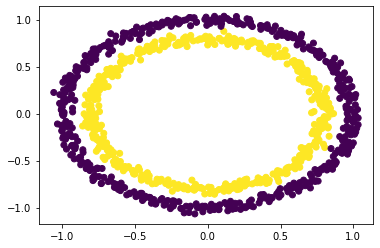

In [43]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
           y=X[:, 1],
           c=y)

In [44]:
#Input and output shapes
X.shape, y.shape

((1000, 2), (1000,))

In [45]:
X_sample = X[0]
y_sample = y[0]
print (X_sample, y_sample)
print (X_sample.shape, y_sample.shape)

[0.75424625 0.23148074] 1
(2,) ()


#### turn data into tensors

In [46]:
import torch
torch.__version__

'2.1.0.dev20230707'

In [47]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [48]:
X.type

<function Tensor.type>

In [49]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [50]:
type(X), X.dtype

(torch.Tensor, torch.float32)

In [51]:
#train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                   random_state=42)

In [52]:
len(X_train), len(y_train)

(800, 800)

#### Agnostic code

In [53]:
import torch
from torch import nn

#Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [54]:
device = 'cpu'
#device = 'mps'

We'll break it down into a few parts.

1)Subclasses nn.Module (almost all PyTorch models are subclasses of nn.Module).

2)Creates 2 nn.Linear layers in the constructor capable of handling the input and output shapes of X and y.

3)Defines a forward() method containing the forward pass computation of the model.

4)Instantiates the model class and sends it to the target device.


#### Creating a linear model

In [55]:
#Construct model that subclaees nn.Modeule
class CirclemodelV0(nn.Module):
    def __init__(self):
        super().__init__()
        #Create nn.Linear layesr capable of hadling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2,out_features=5) # hidden layer
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # output layer
    
    #making fprward pass тут можно черех форвард считать с со слоев как хочешь
    # не ограничавсь только послойоно4
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x->layer_1 -> layer_2 ->output
    
    #ТАКОЙ МЕТОДО ЗАДАНИЯ НЕЙРОСЕТИ(путем наследования) обеспечивает более гибкое задание
    # что и в какойслой передавать чем Sequential model
    
model_0 = CirclemodelV0().to(device)
model_0

CirclemodelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

####  Creating a sequential model

In [56]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [57]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.4708,  0.0808],
                      [ 0.0591, -0.6363],
                      [ 0.0434, -0.2957],
                      [ 0.3553, -0.5834],
                      [ 0.0187, -0.4285]])),
             ('0.bias', tensor([-0.6496, -0.5994, -0.0900,  0.4882, -0.3485])),
             ('1.weight',
              tensor([[-0.1794,  0.4107, -0.3121,  0.3340,  0.3098]])),
             ('1.bias', tensor([-0.4302]))])

In [58]:
# Make some predictions
with torch.inference_mode():
    untrained_preds = models_0(X_test.to(device))
    print (f'Len of untrained preds : {untrained_preds[:10]}, Shape: {untrained_preds.shape}')
       

Len of untrained preds : tensor([[0.2829],
        [0.3446],
        [0.1308],
        [0.3259],
        [0.1465],
        [0.1841],
        [0.3455],
        [0.3080],
        [0.1304],
        [0.3489]]), Shape: torch.Size([200, 1])


#### Los func and optimizer

In [59]:
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in| Needs imputs to go throught sigmoid prior to input BCEloss
loss_fn =   # BCEWithLogitsLoss = sigmoid built-in

In [60]:
optimizer = torch.optim.SGD(params=models_0.parameters(),
                           lr=0.1)

In [61]:
#calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

#### Making a training loop

Training loop

1) Forward pass

2) Calculate the loss

3) Optimizer zero grad

4) Loss backward (backprop)

5) Optimizer step (Gradien descent)


Our model outputs are going to be raw logits. !!!!

We can convert these logits into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to prediction labels by either rounding them or taking the argmax().

### RAW LOGITS -> PREDCITION PROBABILITIES -> CLASS LABELS

In [62]:
model_0.eval()
with torch.inference_mode():
    y_logits = models_0(X_test.to(device))[:5]

In [63]:
y_logits

tensor([[0.2829],
        [0.3446],
        [0.1308],
        [0.3259],
        [0.1465]])

In [64]:
#Turning logits into class probabilities using sigmoid
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5702],
        [0.5853],
        [0.5327],
        [0.5808],
        [0.5366]])

In [65]:
torch.round(y_pred_probs)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [66]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([False, False, False, False, False])


tensor([1., 1., 1., 1., 1.])

In [75]:
device

'cpu'

In [77]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [87]:
epochs = 100

#Pushing data to device

X_train, y_train = X_train.to(device), y_train.to(device)

X_test, y_test = X_test.to(device), y_test.to(device)

# Building training and evaluation loop

for epoch in range(epochs):
    #Training
    model_0.train()
    
    #Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits - >pred provbabilities - > pred labels
    
    # Calculate loss/accuracy
    loss = loss_fn(y_logits,y_train) # Using nn.BCEWithLogitsLoss works with raw logits
    
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # Optimizer zero grad
    
    optimizer.zero_grad()
    
    #Loss backward
    
    loss.backward()
    
    #Optimizert step (gradient descent)
    
    optimizer.step()
    
    ### TEsting 
    
    model_0.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits)) # turn logits - >pred provbabilities - > pred labels
        
        #Calculate testt loss/acc
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
    if epoch % 10 ==0:
        print (f"Epoch: {epoch} | Train_Loss: {loss:.5f} | Test_Loss: {test_loss:.5f}| Train_acc: {acc:.2f}% | Test_acc: {test_acc:.2f}%")
    

Epoch: 0 | Train_Loss: 0.73566 | Test_Loss: 0.72740| Train_acc: 44.00% | Test_acc: 45.50%
Epoch: 10 | Train_Loss: 0.73566 | Test_Loss: 0.72740| Train_acc: 44.00% | Test_acc: 45.50%
Epoch: 20 | Train_Loss: 0.73566 | Test_Loss: 0.72740| Train_acc: 44.00% | Test_acc: 45.50%
Epoch: 30 | Train_Loss: 0.73566 | Test_Loss: 0.72740| Train_acc: 44.00% | Test_acc: 45.50%
Epoch: 40 | Train_Loss: 0.73566 | Test_Loss: 0.72740| Train_acc: 44.00% | Test_acc: 45.50%
Epoch: 50 | Train_Loss: 0.73566 | Test_Loss: 0.72740| Train_acc: 44.00% | Test_acc: 45.50%
Epoch: 60 | Train_Loss: 0.73566 | Test_Loss: 0.72740| Train_acc: 44.00% | Test_acc: 45.50%
Epoch: 70 | Train_Loss: 0.73566 | Test_Loss: 0.72740| Train_acc: 44.00% | Test_acc: 45.50%
Epoch: 80 | Train_Loss: 0.73566 | Test_Loss: 0.72740| Train_acc: 44.00% | Test_acc: 45.50%
Epoch: 90 | Train_Loss: 0.73566 | Test_Loss: 0.72740| Train_acc: 44.00% | Test_acc: 45.50%
